In [331]:
# def get_contrastive_matrix(batch_size, sequence_length, num_augmentations, window_size):
#     total_samples = batch_size* sequence_length * num_augmentations
#     same_sample = torch.zeros((total_samples, total_samples), dtype=torch.int)
#     window_mask = torch.zeros_like(same_sample)
    
#     window_width = window_size//2 +1

#     for i in range(total_samples):
#         i_indices = []
#         for j in range(total_samples):
#             if i // sequence_length == j // sequence_length:
#                 i_indices.append(j)
#         same_sample[i,i_indices] = 1
    
#     # return contrastive_matrix
    
#     for k in range(-window_width, window_width):
#         window_mask += torch.diag(torch.ones((total_samples)),k)[:total_samples,:total_samples].int()
    
#     return same_sample * window_mask

import torch

def get_contrastive_matrix(batch_size, sequence_length, num_augmentations, window_size):
    total_samples = batch_size * sequence_length * num_augmentations

    # Create a matrix indicating whether samples are from the same sequence
    
    diag_block = torch.ones((sequence_length,sequence_length))
    same_sequence = torch.block_diag(*((batch_size * num_augmentations) * [diag_block]))
    

    # Create a window mask
    window_width = window_size // 2 + 1
    window_mask = torch.diag(torch.ones((total_samples)), 0)

    for k in range(1, window_width):
        window_mask += torch.diag(torch.ones((total_samples - k)), k)
        window_mask += torch.diag(torch.ones((total_samples - k)), -k)

    # Apply the window mask
    window_mask = window_mask[:total_samples, :total_samples]
    

    # Return the contrastive matrix
    return (same_sequence + window_mask) * same_sequence, (batch_size,num_augmentations,sequence_length,window_size)

A = get_contrastive_matrix(2,10,2,4)

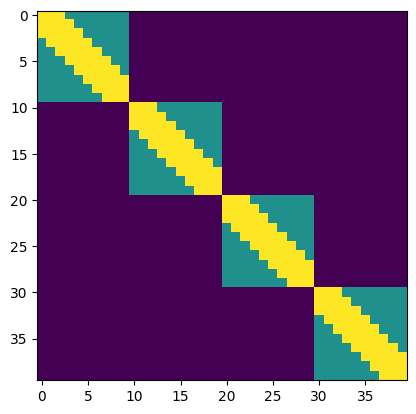

In [332]:
import matplotlib.pyplot as plt

plt.imshow(A[0].numpy())

In [335]:
def expand_contrastive_matrix(contrastive_matrix=None):
    matrix = contrastive_matrix[0]
    B, N, T, W = contrastive_matrix[1]
    new_size = B * N * (T + 1)
    new_matrix = torch.zeros(new_size, new_size)

    # Create indices for block assignment
    indices = torch.arange(0, B * N * T, T)
    delays = indices // T + 1
    for k, delay in zip(indices, delays):
        new_matrix[k + delay : k + delay + T, k + delay : k + delay + T] = matrix[k : k + T, k : k + T]

    indices = torch.arange(0, B * N * (T + 1), T + 1)
    i_indices, j_indices = torch.meshgrid(indices, indices)
    mask = (i_indices // ((T + 1) * N)) == (j_indices // ((T + 1) * N))
    new_matrix[i_indices[mask], j_indices[mask]] = 2
    new_matrix[j_indices[mask], i_indices[mask]] = 2

    return new_matrix, (B, N, T, W)


    
B = expand_contrastive_matrix(A)

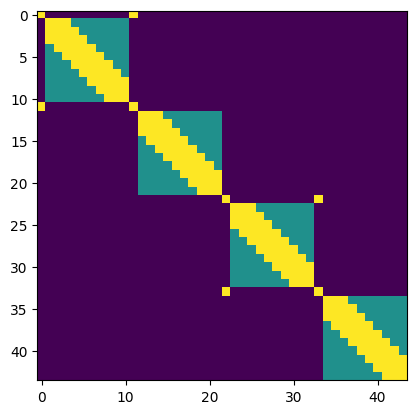

In [336]:
import matplotlib.pyplot as plt

plt.imshow(B[0].numpy())

(2, 2, 10, 4)


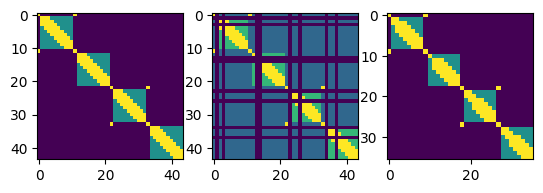

In [337]:
def mask_contrastive_matrix(contrastive_matrix):
    
    matrix = contrastive_matrix[0]
    masked_matrix_blackout = matrix.clone()
    masked_matrix = matrix.clone()
    
    print(contrastive_matrix[1])
    B_mat, N_mat, T_mat, W_mat = contrastive_matrix[1]
    
    retained_idx = [[1,2],[1,2],[1,2],[1,2]]
    masked_idx = [[0,2],[1,2],[0,3],[0,3]]
    
    B = 4
    
    for i in range(B):
        
        cur_retained_idx = retained_idx[i]
        cur_masked_idx = masked_idx[i]
        
        cur_masked_idx_mat = [k+1 + i*(T_mat+1) for k in cur_masked_idx]

        masked_matrix_blackout[cur_masked_idx_mat, :] = -1
        masked_matrix_blackout[:, cur_masked_idx_mat] = -1
    
    index = (masked_matrix_blackout != -1)[0].nonzero().squeeze()
    masked_matrix = matrix[index,:][:,index]
    
    return matrix, masked_matrix_blackout, masked_matrix

C,D,E = mask_contrastive_matrix(B)

fig,ax = plt.subplots(1,3)
ax[0].imshow(C)
ax[1].imshow(D)
ax[2].imshow(E)

(tensor([[2., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 2.,  ..., 0., 0., 0.],
        [0., 2., 2.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 2., 2., 2.],
        [0., 0., 0.,  ..., 2., 2., 2.],
        [0., 0., 0.,  ..., 2., 2., 2.]]), (2, 2, 10, 5))
tensor([1.1386, 9.5322, 8.8576, 8.9575, 8.9730, 8.4872, 8.6590, 8.2204, 8.8584,
        9.2158, 8.9105, 1.1386, 9.2028, 9.3949, 9.1813, 8.7940, 8.8655, 9.0316,
        9.6181, 9.0964, 9.6731, 9.2436, 0.8731, 9.6644, 9.1308, 9.3102, 8.3899,
        8.8638, 9.3063, 9.2612, 8.9945, 8.2162, 8.8977, 0.8731, 8.8321, 9.1312,
        8.9692, 8.3466, 8.9542, 9.3662, 8.0165, 8.5528, 8.9002, 8.6783])


tensor(2.0037)

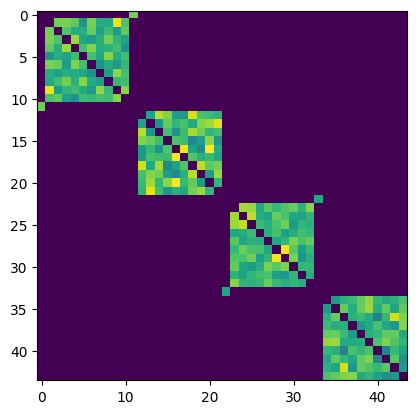

In [346]:
class MySupConLoss(nn.Module):
    
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.first_run = True
        self.sim_function = nn.CosineSimilarity(2)
        
    def forward(self,features, positive_mask, negative_mask):
        
        ## features shape extended_batch, d_model
        ## mask shape extended_batch,extended_batch
        
        ## add zeros to negative and positive masks to prevent self-contrasting
        
        self_contrast = (~(torch.eye(positive_mask.shape[0]).bool())).int()
        
        
        positive_mask = positive_mask * self_contrast
        negative_mask = negative_mask * self_contrast
        
        
        original_cosim = torch.exp(self.sim_function(features.unsqueeze(1),features.unsqueeze(0))/1)
        
        positives = original_cosim * positive_mask
        negatives = original_cosim * negative_mask
        
        plt.imshow(negatives)
        negatives_summed = negatives.sum(1)
        positives_negged = positives / negatives_summed
        
        positives_negged = torch.nan_to_num(torch.log(positives_negged), neginf=0)
        
        
        positive_cardinal = - positive_mask.sum(1)
        # print(positive_cardinal)
        # print(positives_negged.sum(1))
        
        loss = positives_negged.sum(1)/positive_cardinal
        # plt.imshow(loss)
        loss = loss.mean()
        
        return loss
    
test_data = torch.randn(44,44)
test_positive_mask = get_contrastive_matrix(2,10,2,5)
test_positive_mask = expand_contrastive_matrix(test_positive_mask)

print(test_positive_mask)



test_negative_mask = test_positive_mask[0] > 0
test_positive_mask = (test_positive_mask[0]) ==2


loss = MySupConLoss()

loss(test_data,test_positive_mask,test_negative_mask)


In [341]:
test_positive_mask

tensor([[ True, False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False,  True,  True,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False,  True,  True,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False,  True,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, Fa